In [12]:
import pandas as pd

df = pd.read_csv("AB_NYC_2019.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: 'AB_NYC_2019.csv'

In [5]:
df.dtypes

NameError: name 'df' is not defined

In [6]:
new_df = df.drop(['latitude', 'longitude'], axis = 1)
new_df

NameError: name 'df' is not defined

In [7]:
new_df.columns = (
    new_df.columns
        .str.strip()              # remove leading/trailing spaces
        .str.lower()
        .str.replace(" ", "_")  # replace internal spaces with _
)
new_df.columns

new_df.rename(columns={'id': 'listing_id'}, inplace=True)
new_df.rename(columns={'name': 'listing_name'}, inplace=True)
new_df.tail()
#new_df.isna().any()

NameError: name 'new_df' is not defined

In [8]:
new_df['host_name'].unique()

NameError: name 'new_df' is not defined

In [9]:
new_df['neighbourhood_group'].unique()

NameError: name 'new_df' is not defined

In [10]:
#new_df['full_location'] = new_df['neighbourhood'].str.cat(new_df['neighbourhood_group'], sep = ', ')
#new_df.head()

In [11]:
new_df['neighbourhood'].unique()

NameError: name 'new_df' is not defined

In [20]:
import pandas as pd
import os

# BASIC CONFIGURATION
FILE_PATH = "C:/Users/ASUS/Desktop/courses/projects/week_3/cleaned_airbnb.csv"
OUTPUT_DIR = "C:/Users/ASUS/Desktop/courses/projects/week_3" 


# 1 DATA LOAD
try:
    # Read the main CSV file
    df = pd.read_csv(FILE_PATH)
    
    # Rename 'id' to 'listing_id' for clarity in the final schema
    df.rename(columns={'id': 'listing_id', 'name': 'listing_name'}, inplace=True)
    
    print(f"Successfully loaded {len(df)} rows from the original CSV.")

except FileNotFoundError:
    print(f"Error: The file was not found at {FILE_PATH}")
    exit()
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    exit()


# 2 CREATE HOST_DF
print("Creating host_df.csv...")
host_columns = [
    'host_id', 
    'host_name', 
    'number_of_reviews', 
    'last_review', 
    'reviews_per_month',
    'calculated_host_listings_count'
]

# Select columns and drop duplicates based on the primary key (host_id)
host_df = df[host_columns].drop_duplicates(subset=['host_id'], keep='first').copy()

# Fill NaN values for reviews columns with 0, as many listings might not have reviews
host_df['reviews_per_month'] = host_df['reviews_per_month'].fillna(0)
host_df['last_review'] = host_df['last_review'].fillna('N/A')

# Save the resulting DataFrame
output_path_host = os.path.join(OUTPUT_DIR, 'host_df.csv')
host_df.to_csv(output_path_host, index=False)
print(f"-> host_df.csv created successfully with {len(host_df)} unique hosts.")


# --- 3. Create listing_df.csv ---
print("Creating listing_df.csv...")
listing_columns = [
    'listing_id', 
    'host_id', 
    'neighbourhood',
    'listing_name', 
    'room_type', 
    'price', 
    'minimum_nights', 
    'availability_365'
]

# Since listing_id is the primary key and every row in the original file is a unique listing,
# we just select the required columns.
listing_df = df[listing_columns].copy()

# Save the resulting DataFrame
output_path_listing = os.path.join(OUTPUT_DIR, 'listing_df.csv')
listing_df.to_csv(output_path_listing, index=False)
print(f"-> listing_df.csv created successfully with {len(listing_df)} listings.")


# --- 4. Create neighbourhood_df.csv ---
print("Creating neighbourhood_df.csv...")
neighbourhood_columns = [
    'neighbourhood', 
    'neighbourhood_group', 
    'listing_id' # Note: We include listing_id here for clarity, but the PK should be 'neighbourhood'
]

# Select columns and drop duplicates based on the primary key (neighbourhood)
# Note: For the 'neighbourhood' table, the neighbourhood should be unique. 
# We'll keep the data associated with the first listing_id found for that neighbourhood.
neighbourhood_df = df.drop_duplicates(subset=['neighbourhood'], keep='first')[neighbourhood_columns].copy()

# Save the resulting DataFrame
output_path_neighbourhood = os.path.join(OUTPUT_DIR, 'neighbourhood_df.csv')
neighbourhood_df.to_csv(output_path_neighbourhood, index=False)
print(f"-> neighbourhood_df.csv created successfully with {len(neighbourhood_df)} unique neighbourhoods.")

print("\n--- Process Complete ---")

Successfully loaded 48895 rows from the original CSV.
Creating host_df.csv...
-> host_df.csv created successfully with 37457 unique hosts.
Creating listing_df.csv...
-> listing_df.csv created successfully with 48895 listings.
Creating neighbourhood_df.csv...
-> neighbourhood_df.csv created successfully with 221 unique neighbourhoods.

--- Process Complete ---


In [15]:
# CHECK IF HOST DF HAS DUPLICATES
import pandas as pd

# --- Configuration ---
FILE_PATH = "C:/Users/ASUS/Desktop/courses/projects/week_3/host_df.csv"
KEY_COLUMN = 'host_id'

# --- Load the Data ---
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded {len(df)} rows from the host_df.csv.")
except FileNotFoundError:
    print(f"Error: The file was not found at {FILE_PATH}")
    exit()
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    exit()

# --- Check for Duplicates ---

# 1. Identify all rows that are duplicates based on the host_id column
# The 'False' values represent the unique first occurrences of each host_id.
# The 'True' values represent the duplicate rows (second, third, etc., occurrences).
duplicate_rows = df.duplicated(subset=[KEY_COLUMN], keep=False)

# 2. Filter the DataFrame to show only the rows that are duplicates
duplicates = df[duplicate_rows].sort_values(by=KEY_COLUMN)

# 3. Calculate the count of unique host_id values that appear more than once
# We divide by the number of times each ID appears to get the count of unique duplicates
num_duplicate_ids = (duplicate_rows.sum() - len(duplicates[KEY_COLUMN].unique())) / (duplicates.groupby(KEY_COLUMN).size().iloc[0] - 1) if not duplicates.empty else 0
num_duplicate_rows = duplicate_rows.sum()

# --- Output Results ---
print("\n--- Duplicate Check Results ---")

if num_duplicate_rows > 0:
    print(f"🚨 DUPLICATES FOUND! 🚨")
    print(f"Total rows involved in duplication: {num_duplicate_rows}")
    print(f"Total unique {KEY_COLUMN} values that are duplicated: {len(duplicates[KEY_COLUMN].unique())}")
    
    print("\nDisplaying the first 20 duplicate entries (sorted by host_id):")
    print("-" * 50)
    print(duplicates.head(20).to_string())
    print("-" * 50)
    print("If duplicates are found, you must clean the CSV before importing it again.")
else:
    print(f"✅ SUCCESS! No duplicate '{KEY_COLUMN}' values found in host_df.csv.")
    print("You can proceed with the MySQL import.")

Successfully loaded 37457 rows from the host_df.csv.

--- Duplicate Check Results ---
✅ SUCCESS! No duplicate 'host_id' values found in host_df.csv.
You can proceed with the MySQL import.


In [16]:
import pandas as pd
import os

#  Re-check the File Paths 
FILE_PATH = "C:/Users/ASUS/Desktop/courses/projects/week_3/cleaned_airbnb.csv"
OUTPUT_DIR = "C:/Users/ASUS/Desktop/courses/projects/week_3"

# Load and rename original columns
df = pd.read_csv(FILE_PATH).rename(columns={'id': 'listing_id', 'name': 'listing_name'})

# Clean host_df data 
host_columns = [
    'host_id', 
    'host_name', 
    'number_of_reviews', 
    'last_review', 
    'reviews_per_month',
    'calculated_host_listings_count'
]

# CRITICAL: Drop duplicates to ensure unique host_id
host_df_cleaned = df[host_columns].drop_duplicates(subset=['host_id'], keep='first').copy()

# Handle missing values
host_df_cleaned['reviews_per_month'] = host_df_cleaned['reviews_per_month'].fillna(0)
host_df_cleaned['last_review'] = host_df_cleaned['last_review'].fillna('N/A')

# Save the new, clean file, overwriting the old one
output_path_host = os.path.join(OUTPUT_DIR, 'host_df.csv')
host_df_cleaned.to_csv(output_path_host, index=False)

print(f"host_df.csv successfully cleaned and saved with {len(host_df_cleaned)} unique host entries.")

host_df.csv successfully cleaned and saved with 37457 unique host entries.


In [17]:
# CHECK FOR COLUMNS IN LISTING_DF.CSV

import pandas as pd
import os

# Define the exact file path
FILE_PATH = "C:/Users/ASUS/Desktop/courses/projects/week_3/listing_df.csv"

def get_csv_columns(file_path):
    """
    Reads a CSV file using Pandas and returns a list of its column names.
    """
 

if __name__ == "__main__":
    get_csv_columns(FILE_PATH)

Attempting to read file: C:/Users/ASUS/Desktop/courses/projects/week_3/listing_df.csv
----------------------------------------
✅ Columns found in listing_df.csv:
----------------------------------------
1. listing_id
2. host_id
3. listing_name
4. room_type
5. price
6. minimum_nights
7. availability_365
----------------------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_52088\1900683451.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Room Type', y='Avg Listing Price', data=df, palette=colors)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_52088\1900683451.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Room Type', y='Avg Revenue per Booking', data=df, palette=colors)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_52088\1900683451.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Room Type', y='Avg Minimum Nights', data=df, palette=colors)


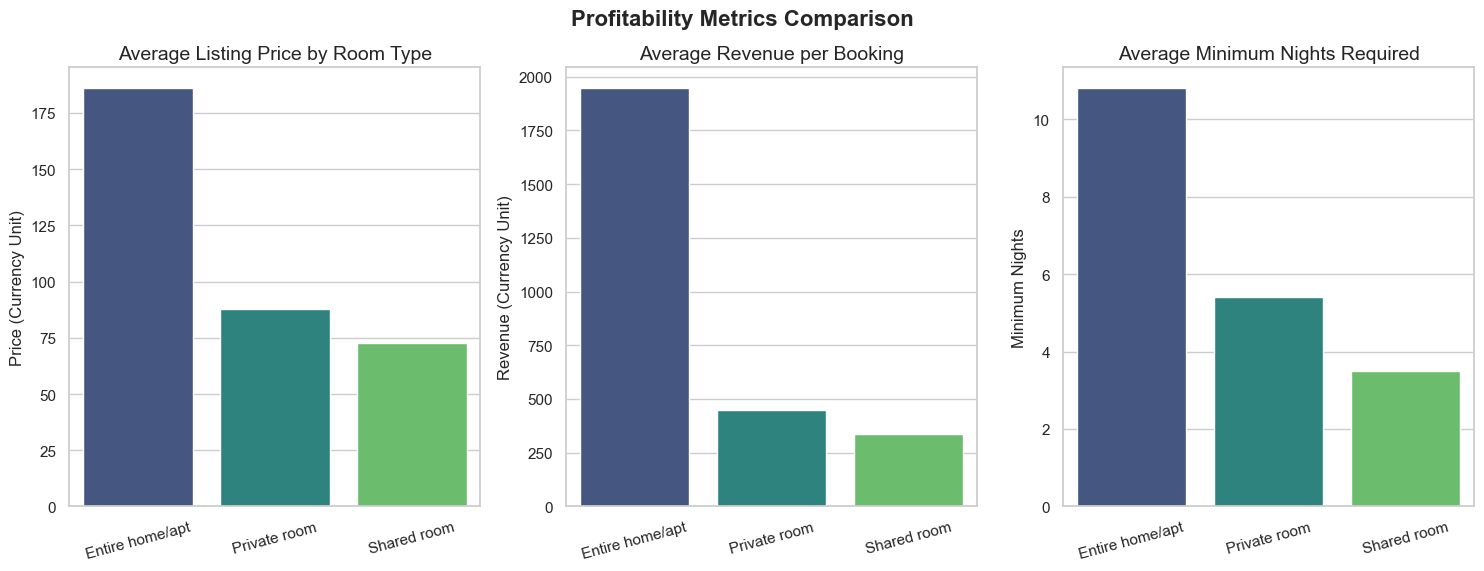

C:\Users\ASUS\AppData\Local\Temp\ipykernel_52088\1900683451.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Room Type', y='Avg Availability (Days)', data=df, palette=colors)


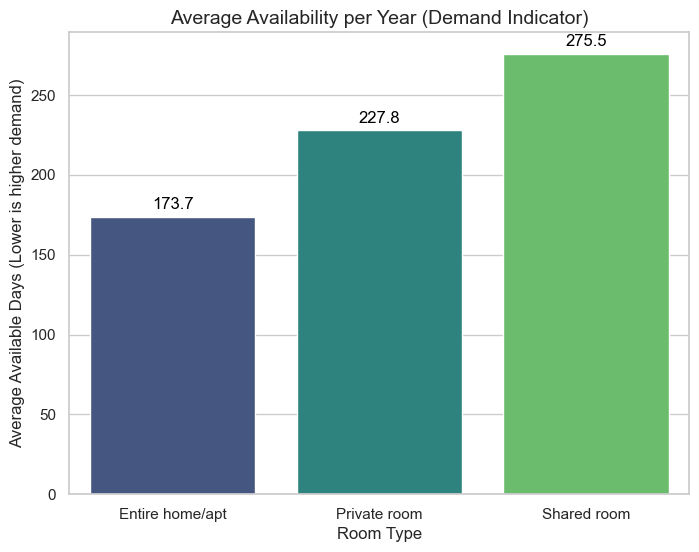


--- Processed Data Summary ---
| Room Type       |   Avg Listing Price |   Avg Minimum Nights |   Avg Revenue per Booking |   Avg Availability (Days) |
|:----------------|--------------------:|---------------------:|--------------------------:|--------------------------:|
| Entire home/apt |              186.01 |                 10.8 |                   1945.78 |                     173.7 |
| Private room    |               88.03 |                  5.4 |                    447.16 |                     227.8 |
| Shared room     |               72.5  |                  3.5 |                    335    |                     275.5 |
------------------------------



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FILE_NAME = "profitability and demand assessment 1.csv"

def generate_visualizations(file_path):
    """
    Reads the profitability data, cleans column names, and generates 
    visualizations for key metrics.
    """
    try:
        # 1. Load the data
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"file '{file_path}' not found.")
        print("Weong path.")
        return
    except Exception as e:
        print(f"file reading error: {e}")
        return

    df.columns = df.columns.str.strip().str.replace('\n', ' ').str.lower()
    df.rename(columns={
        'room_type': 'Room Type',
        'average_listing_price': 'Avg Listing Price',
        'avg_minimum_nights': 'Avg Minimum Nights',
        'avg_minimum_revenue_per_booking': 'Avg Revenue per Booking',
        'avg_availability_per_year': 'Avg Availability (Days)'
    }, inplace=True)

    sns.set_theme(style="whitegrid")

    colors = sns.color_palette("viridis", n_colors=len(df))


    plt.figure(figsize=(15, 6))

  
    plt.subplot(1, 3, 2)
    sns.barplot(x='Room Type', y='Avg Revenue per Booking', data=df, palette=colors)
    plt.title('Average Revenue per Booking', fontsize=14)
    plt.ylabel('Revenue (Currency Unit)', fontsize=12)
    plt.xlabel('')
    plt.xticks(rotation=15)


    plt.figure(figsize=(8, 6))
    
    sns.barplot(x='Room Type', y='Avg Availability (Days)', data=df, palette=colors)
    plt.title('Average Availability per Year (Demand Indicator)', fontsize=14)
    plt.ylabel('Average Available Days (Lower is higher demand)', fontsize=12)
    plt.xlabel('Room Type', fontsize=12)
    
    for index, row in df.iterrows():
        plt.text(index, row['Avg Availability (Days)'] + 5, 
                 f"{row['Avg Availability (Days)']:.1f}", 
                 color='black', ha="center")

    plt.show()
    

# Execute the function
if __name__ == "__main__":
    generate_visualizations(FILE_NAME)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_52088\1620542420.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


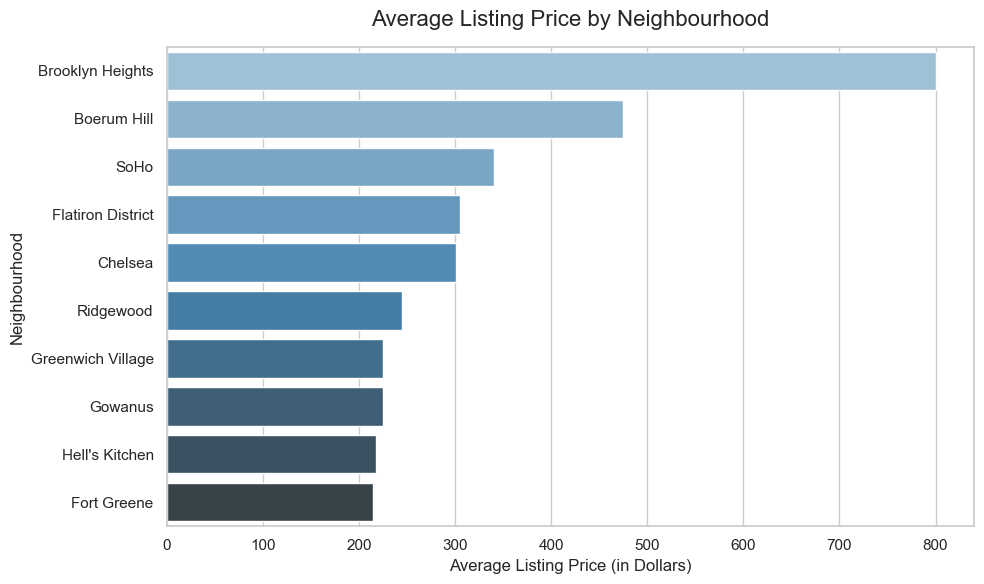

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FILE_NAME = "profitability and demand assessment 3 - filtered only full homes.csv"

df = pd.read_csv(FILE_NAME)
df_sorted = df.sort_values(by='average_listing_price', ascending=False)

df_sorted.rename(columns={'neighbourhood': 'Neighbourhood', 
                           'average_listing_price': 'Average Listing Price'}, inplace=True)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    x='Average Listing Price', 
    y='Neighbourhood', 
    data=df_sorted, 
    palette='Blues_d'
)

plt.title('Average Listing Price by Neighbourhood', fontsize=16, pad=15)
plt.xlabel('Average Listing Price (in Dollars)', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)

plt.tight_layout()
plt.savefig('neighbourhood_avg_listing_price_blue_bar_chart.png')